## 0. Load libraries and custom functions

In [1]:
from functions import load_taxi_trip_data, concat_dataframes, load_taxi_zones_shp, map_taxi_zone_to_cdta,\
                    add_features, get_cdta_df, get_cdta_df_per_month, load_cdta_df, load_cdta_df_per_month,\
                    plot_total_trips, plot_trips_per_month, plot_on_map

import geopandas as gpd
import os

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## * If CSV files are already available, download them and start directly from 4. EDA.

In [2]:
cdta_df = load_cdta_df(folder_name="Download\\cdta_df")
dfs, year_months = load_cdta_df_per_month(folder_name="Download\\cdta_df",
                        year_month_list = ['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06'])

cdta_df loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-01.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-02.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-03.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-04.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-05.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-06.csv loaded from c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_DO_2022-01.csv loade

## 1. Load taxi trip data
- Download taxi trip data in the local drive and load them as dataframes.
<br><br>
- Note: Only yellow and green taxi trip data from Jan-Jun 2022 will be used due to limited resources.
- Data source: NYC Taxi and Limousine Commission (TLC)

In [2]:
source_url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
dataframes = load_taxi_trip_data(source_url, folder_name="Download")

yellow_tripdata_2022-01.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\yellow.
green_tripdata_2022-01.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\green.
yellow_tripdata_2022-02.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\yellow.
green_tripdata_2022-02.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\green.
yellow_tripdata_2022-03.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\yellow.
green_tripdata_2022-03.parquet already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\green.
yellow_tripdata_2022-04.parquet already exists in c:\Users\Admin\Documents\G

<br>
Concatenate yellow and green taxi dataframes as a single dataframe since they mostly share common columns and the distinction between the two is not necessary in our analysis.

In [3]:
street_hail_df_original = concat_dataframes(dataframes)
street_hail_df_original.head()

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,ehail_fee,trip_type
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1.0,...,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,NaN,NaN
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1.0,...,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,NaN,NaN
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1.0,...,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,NaN,NaN
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2.0,...,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,NaN,NaN
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1.0,...,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,NaN,NaN


## 2. Map taxi zones into CDTAs
### 2-1. Download taxi zones data in the local drive and load .shp file as dataframe.
- Note: The taxi zones are roughly based on NYC Department of City Planning’s Neighborhood Tabulation Areas (NTAs).
- Reference: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
<br><br>
- Note: Community District Tabulation Areas (CDTAs), which closely approximate Community Districts (CDs).
- Reference: https://storymaps.arcgis.com/stories/d30850ba28944619b94e8ee4f746d5c4

In [4]:
taxi_zones_df = load_taxi_zones_shp(source_url, folder_name="Download\\taxi_zones", target_filename = "taxi_zones.zip")
print(f"Number of unique taxi zones: {len(taxi_zones_df.zone.unique())}")
taxi_zones_df.head()

taxi_zones.zip already exists in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\taxi_zones.
Number of unique taxi zones: 260


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


### 2-2. Load Neighborhood Tabulation Areas (NTAs) data, which needs to be downloaded manually.
- Note: Multiple NTAs belong to a single Community District Tabulation Areas (CDTA).
- Data source: https://ssrc.formstack.com/forms/moa_d2g

In [5]:
nynta2020_df = gpd.read_file(os.getcwd()+"\\Download\\nynta2020_22b\\nynta2020.shp")
print(f"Number of unique NTAs: {len(nynta2020_df.NTA2020.unique())}") # 262 NTAs
print(f"Number of unique CDTAs: {len(nynta2020_df.CDTA2020.unique())}") # 71 CDTAs, including 59 community districts
nynta2020_df.head()

Number of unique NTAs: 262
Number of unique CDTAs: 71


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28914.355951,3.532200e+07,"POLYGON ((1003059.997 204572.025, 1002950.775 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28155.614512,2.886227e+07,"POLYGON ((995851.915 203199.331, 995969.192 20..."
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18252.346181,1.520934e+07,"POLYGON ((998047.210 196303.325, 998157.901 19..."
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.868945,5.226612e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ..."
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14337.876099,9.985373e+06,"POLYGON ((986367.735 190549.239, 985813.835 19..."


### 2-3. Map taxi zones into CDTA and update taxi_zones_df with the mapping information.

In [6]:
taxi_zones_df, idx_dict = map_taxi_zone_to_cdta(nynta2020_df, taxi_zones_df)

### 2-4. Check taxi zones that did not have a match in NTAs.

In [7]:
taxi_zones_not_in_nta = set(taxi_zones_df.LocationID).difference(set(idx_dict.keys()))
print(f"Taxi zones not mapped to any NTA: {taxi_zones_not_in_nta}")
taxi_zones_df[taxi_zones_df.LocationID==list(taxi_zones_not_in_nta)[0]]

Taxi zones not mapped to any NTA: {1}


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,NTA,CDTA,CDTA_name
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",,,


Since Newark Airport is located outside of NYC, manually add CDTA and its name.

In [8]:
taxi_zones_df.loc[0, "CDTA"] = "EWR (Newark Airport)"
taxi_zones_df.loc[0, "CDTA_name"] = "EWR (Newark Airport)"

### 2-5. Add borough for each CDTA to taxi_zones_df.

In [9]:
taxi_zones_df['borough'] = taxi_zones_df["CDTA"].apply(lambda x: "EWR" if "EWR" in x else x[:2]).map(
    {
        'EWR': 'EWR',
        'QN': 'Queens',
        'BX': 'Bronx',
        'MN': 'Manhattan',
        'SI': 'Staten Island',
        'BK': 'Brooklyn'
    }
)
taxi_zones_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,NTA,CDTA,CDTA_name
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",,EWR (Newark Airport),EWR (Newark Airport)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",QN8491,QN84,QN84 Jamaica Bay (East) (JIA 84 Approximation)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",BX1103,BX11,BX11 Pelham Parkway-Morris Park (CD 11 Approxi...
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",MN0303,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",SI0303,SI03,SI03 South Shore (CD 3 Approximation)


### 2-6. Lastly, create dictionaries and a list  that will be used for filtering and feature engineering.

In [10]:
cdta_geo_dict = {}
for cdta in taxi_zones_df["CDTA"].unique():
    cdta_geo_dict[cdta] = taxi_zones_df[taxi_zones_df["CDTA"] == cdta]["geometry"].unary_union

taxi_zone_dict = taxi_zones_df.set_index("LocationID")[["geometry", "CDTA", "CDTA_name"]].to_dict()

zone_borough_dict = taxi_zones_df.set_index("LocationID")["borough"].to_dict()

zones_in_manhattan_list = list(taxi_zones_df[taxi_zones_df["borough"] == "Manhattan"]["LocationID"].values)

## 3. Data cleaning and feature engineering
### 3-1. Drop unnecessary data from the taxi trip dataframe.

In [11]:
# Drop columns to reduce memory required for the dataframe.
cols_to_keep = ["PULocationID", "DOLocationID", "pickup_datetime", "dropoff_datetime",
                "passenger_count", "trip_distance", "total_amount", "congestion_surcharge", "airport_fee"]
street_hail_df = street_hail_df_original[cols_to_keep]

# Drop rides from and to locations that are not found in the taxi zone dataframe.
street_hail_df = street_hail_df[street_hail_df.PULocationID.isin(taxi_zones_df.LocationID) & \
                                street_hail_df.DOLocationID.isin(taxi_zones_df.LocationID)]

# Drop rides whose pickup_datetime or dropoff_datetime is not in between 1 Jan 2022 and 30 Jun 2022;
# Jul 2022 trip data are not complete as of 9 Nov 2022, thus dropping them to get proper monthly stats.
street_hail_df = street_hail_df[(street_hail_df['pickup_datetime'] >= '2022-01-01') & \
                                (street_hail_df['dropoff_datetime'] >= '2022-01-01') & \
                                (street_hail_df['pickup_datetime'] < '2022-07-01') & \
                                (street_hail_df['dropoff_datetime'] < '2022-07-01')]

# Drop rides without a passenger; 398,183 out of 19,893,903 rows (2% of the total rows).
street_hail_df = street_hail_df[street_hail_df['passenger_count'] > 0]

### 3-2. Add features to street_hail_df.

In [12]:
street_hail_df = add_features(street_hail_df, zone_borough_dict, taxi_zone_dict)

Adding "PU_borough" to street_hail_df based on pickup locations.
Adding "DO_borough" to street_hail_df based on dropoff locations.
Adding "PU_CDTA" to street_hail_df based on pickup locations.
Adding "DO_CDTA" to street_hail_df based on dropoff locations.
Adding "duration" to street_hail_df based on pickup and dropoff datetimes.
Splitting "pickup_datetime" into multiple columns (day, hour, weekday, and year_month).
Splitting "dropoff_datetime" into multiple columns (day, hour, weekday, and year_month).


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\core.py:4005: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [13]:
%%time
print("""
Computing dask.dataframe street_hail_df for the next step.
This could take around 10 minutues due to the volume of the data - 19 million+ rows.
""")
street_hail_df = street_hail_df.fillna(0).compute()


Computing dask.dataframe street_hail_df for the next step.
This could take around 10 minutues due to the volume of the data - 19 million+ rows.

Wall time: 11min 13s


### 3-3. Get a dataframe containing statistics about taxi trips on pickup and dropoff CDTAs.

In [14]:
%%time
cdta_df = get_cdta_df(street_hail_df, cdta_geo_dict, taxi_zones_df, folder_name="Download\\cdta_df")

cdta_df saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
Wall time: 6min 14s


### 3-4. Get a dataframe for each month in Jan-Jun 2022, for pickup and dropoff separately.

In [15]:
%%time
dfs, year_months = get_cdta_df_per_month(street_hail_df, cdta_geo_dict, taxi_zones_df, folder_name="Download\\cdta_df")

cdta_df_PU_2022-01.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-03.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-02.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-04.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-05.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_PU_2022-06.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_DO_2022-01.csv saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\Download\cdta_df.
cdta_df_DO_2022-03.csv saved in c:

### 4. Visualizations
### 4-1. Based on pickup CDTA
#### 4-1-1. Plot total and monthly trip count for each day, hour, and weekday for each borough.

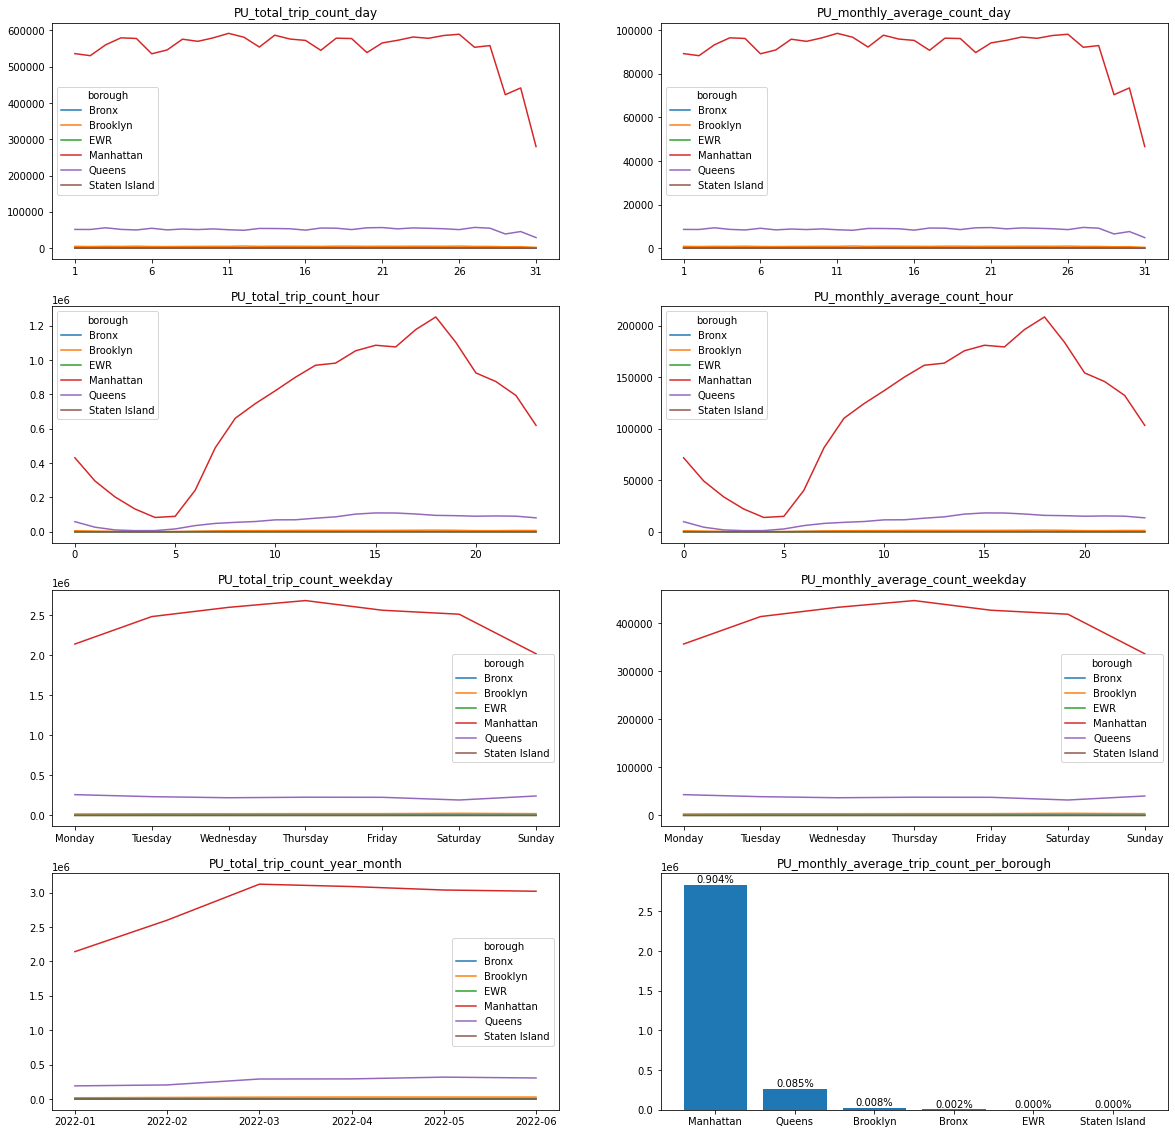

In [16]:
plot_total_trips(cdta_df, pu_do = "PU", single_month=False, year_month=None, save_png=False)

#### 4-1-2. Plot the same variables as above but for each month in Jan-Jun 2022.

In [17]:
plot_trips_per_month(dfs, year_months, pu_do="PU")

PU_2022-01.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
PU_2022-03.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
PU_2022-02.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
PU_2022-04.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
PU_2022-05.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
PU_2022-06.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
Getting a GIF file using the PNG files.


![gif](png/trip_counts_per_month.gif)

#### 4-1-3. Plot sum and average of passenger count, total fare, congestion charge, airport fee, duration, trip distance, minute per mile, and total trip count for each CDTA on the map of NYC.

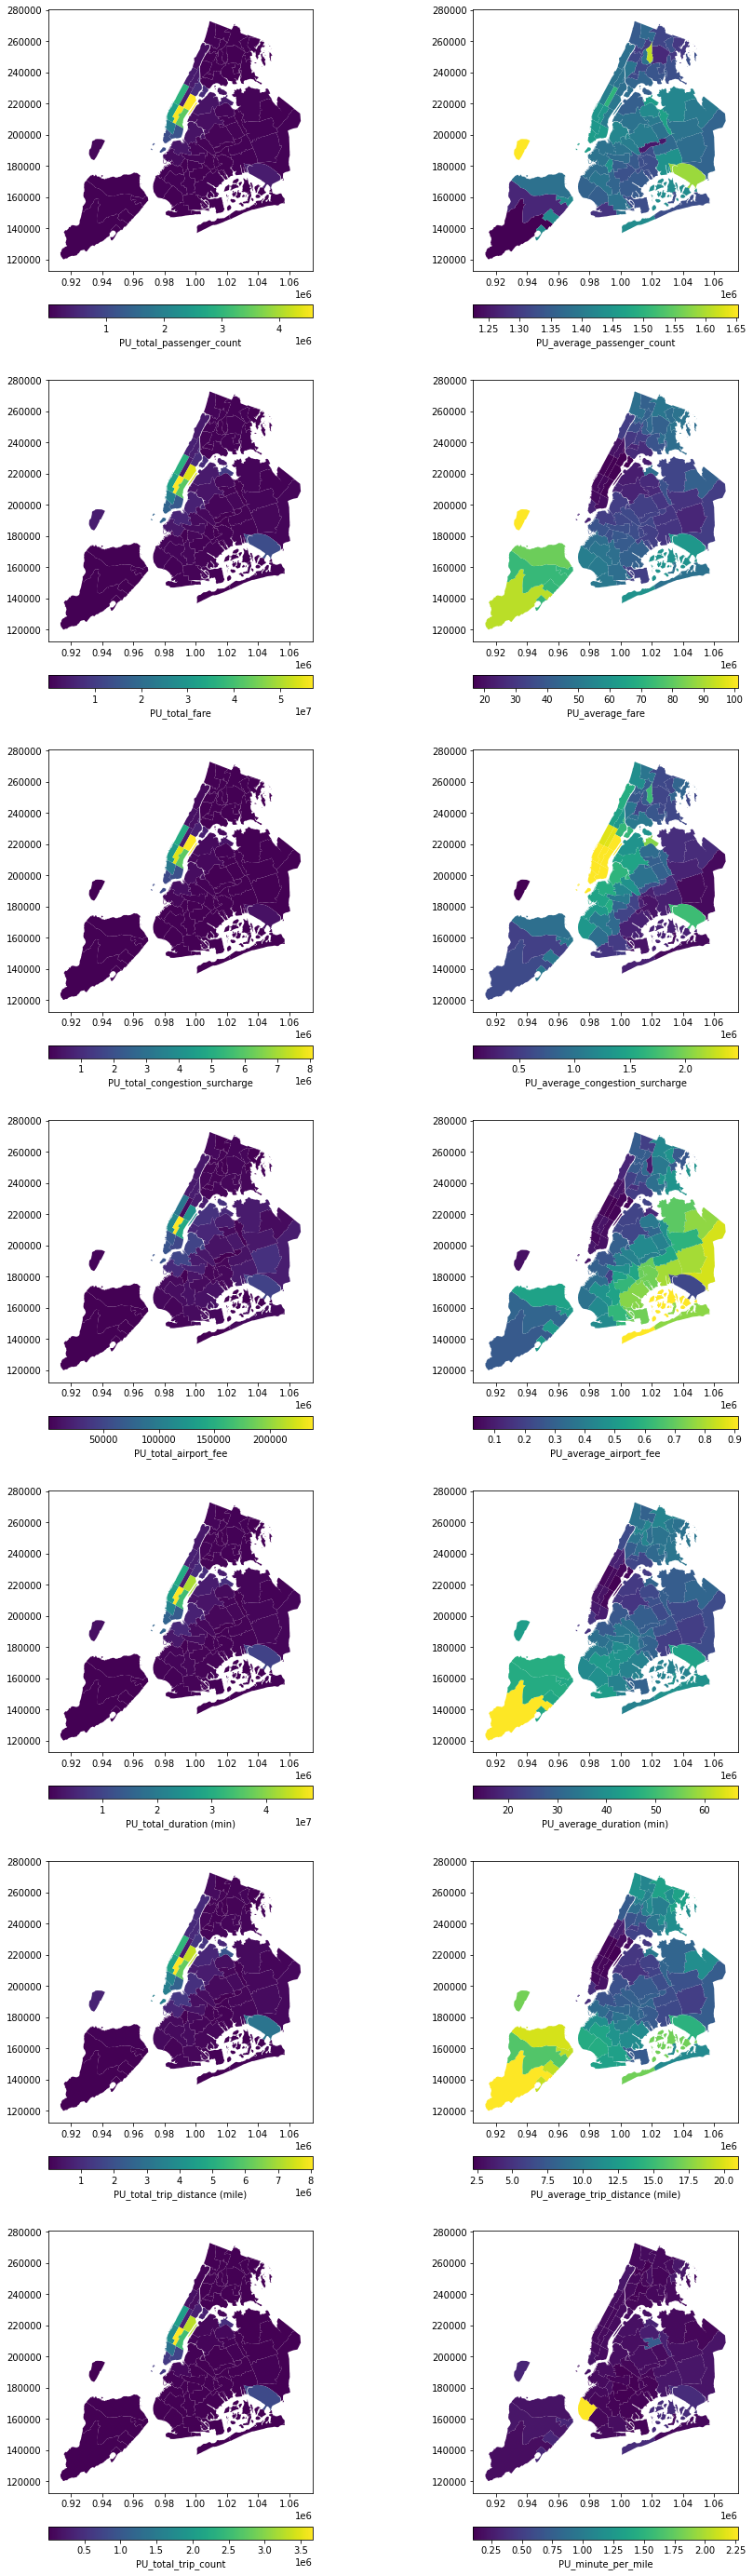

In [3]:
plot_on_map(cdta_df, pu_do="PU")

#### 4-1-4. Plot the same variables as above but excluding Manhattan, where around 90% of taxi trips happened, to see if there are any interesting patterns in other boroughs.

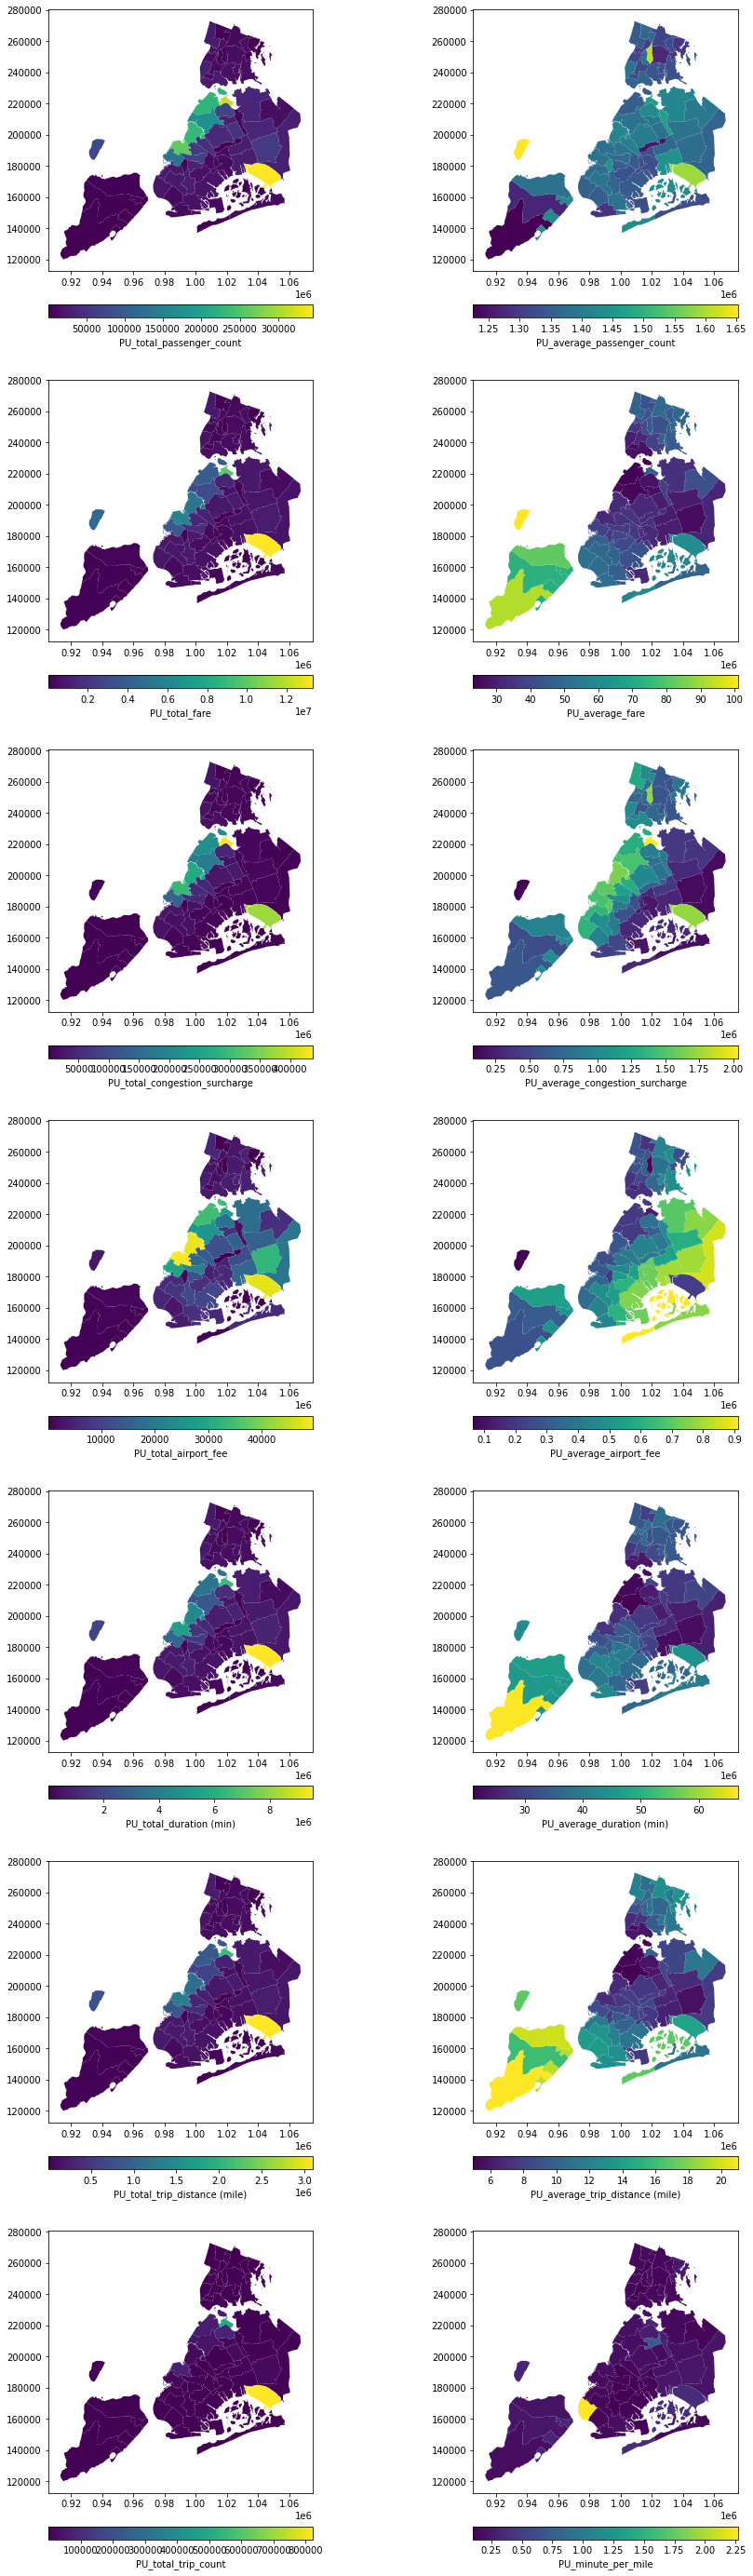

In [4]:
plot_on_map(cdta_df[cdta_df['borough'] != "Manhattan"], pu_do="PU")

### 4-2. Based on dropoff CDTA
#### 4-2-1. Plot total and monthly trip count for each day, hour, and weekday for each borough.

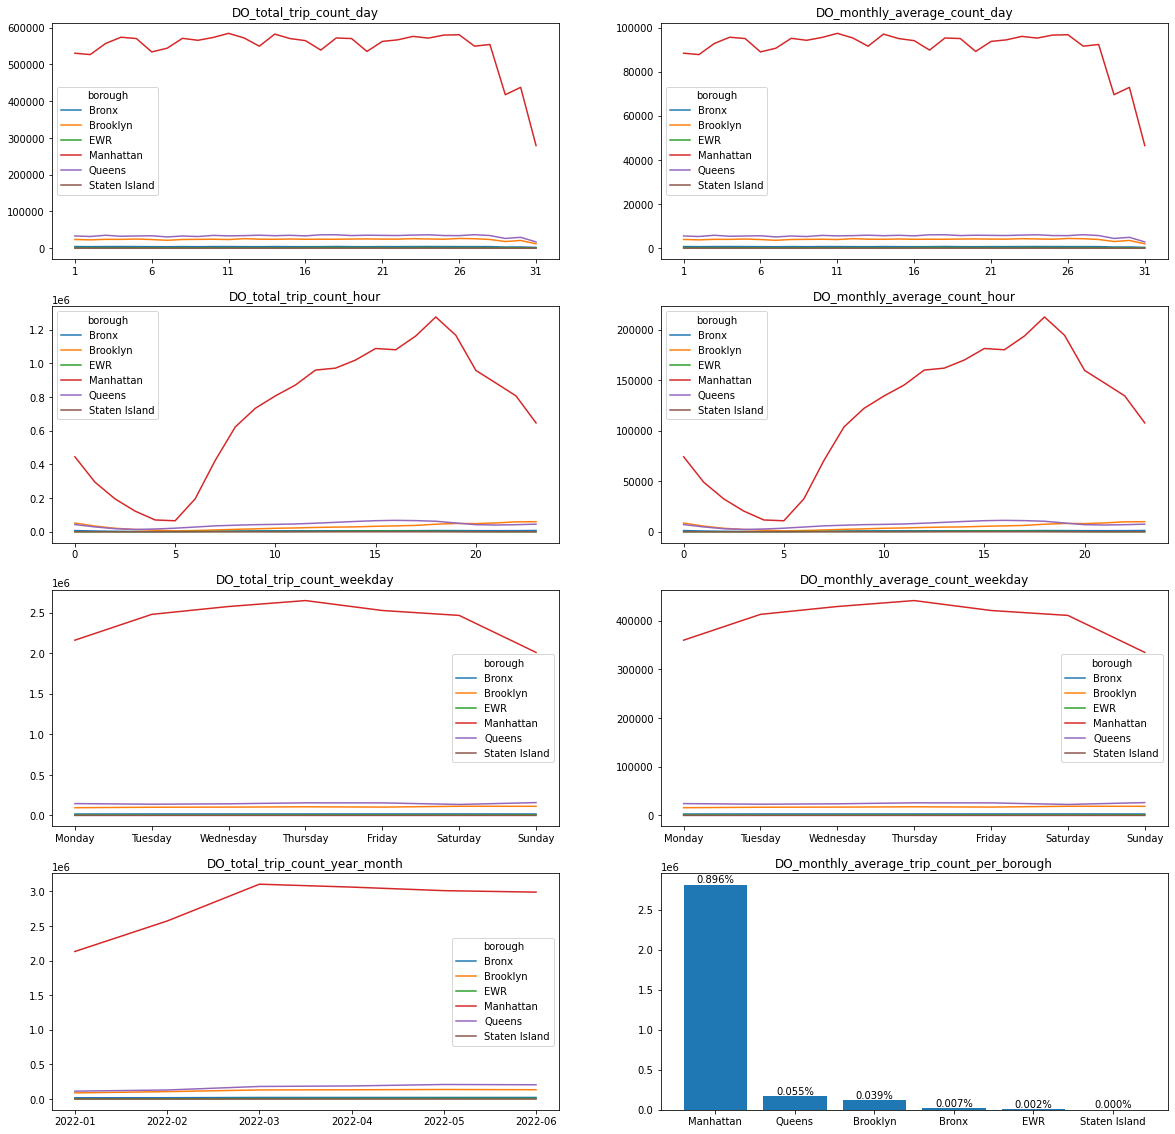

In [5]:
plot_total_trips(cdta_df, pu_do = "DO", single_month=False, year_month=None, save_png=False)

#### 4-2-2. Plot the same variables as above but for each month in Jan-Jun 2022.

In [6]:
plot_trips_per_month(dfs, year_months, pu_do="DO")

DO_2022-01.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
DO_2022-02.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
DO_2022-03.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
DO_2022-04.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
DO_2022-05.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
DO_2022-06.png saved in c:\Users\Admin\Documents\GitHub\NYC-Transportation-and-Socioeconomic-Data-Analysis\taxi\png.
Getting a GIF file using the PNG files.


#### 4-2-3. Plot sum and average of passenger count, total fare, congestion charge, airport fee, duration, trip distance, minute per mile, and total trip count for each CDTA on the map of NYC.

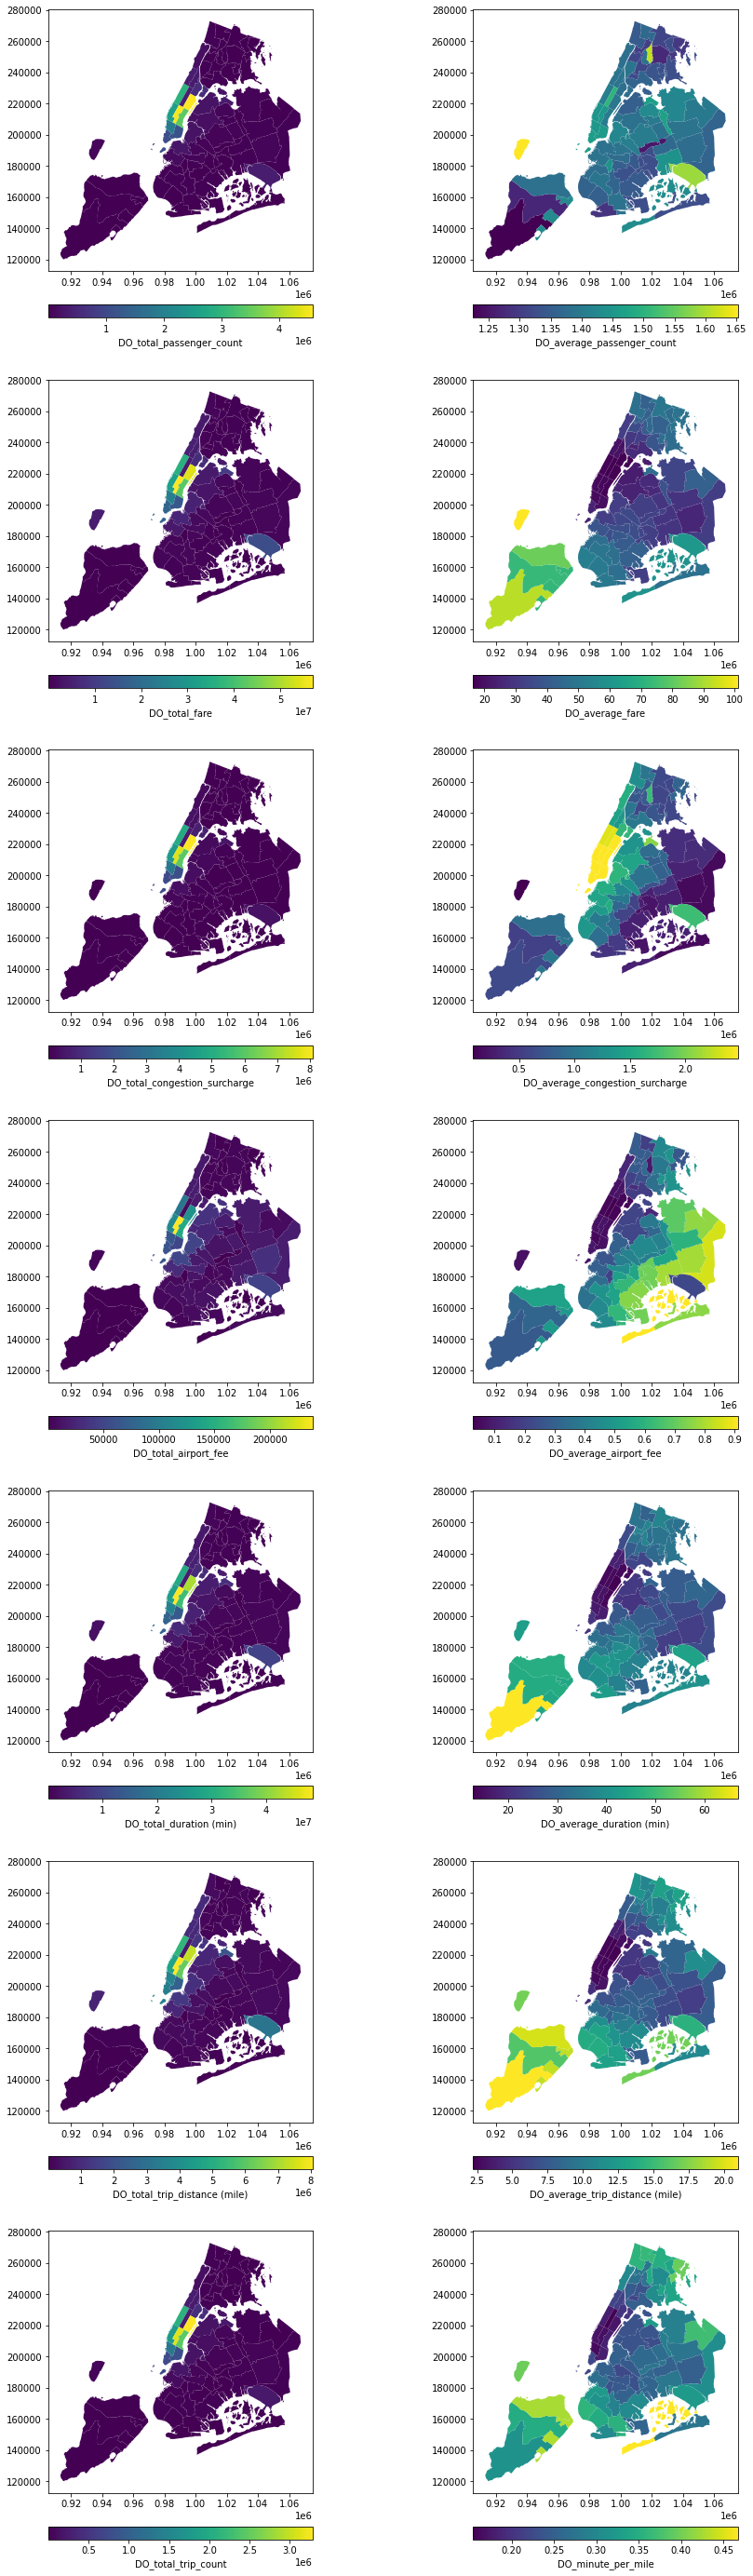

In [7]:
plot_on_map(cdta_df, pu_do="DO")

#### 4-2-4. Plot the same variables as above but excluding Manhattan, where around 90% of taxi trips happened, to see if there are any interesting patterns in other boroughs.

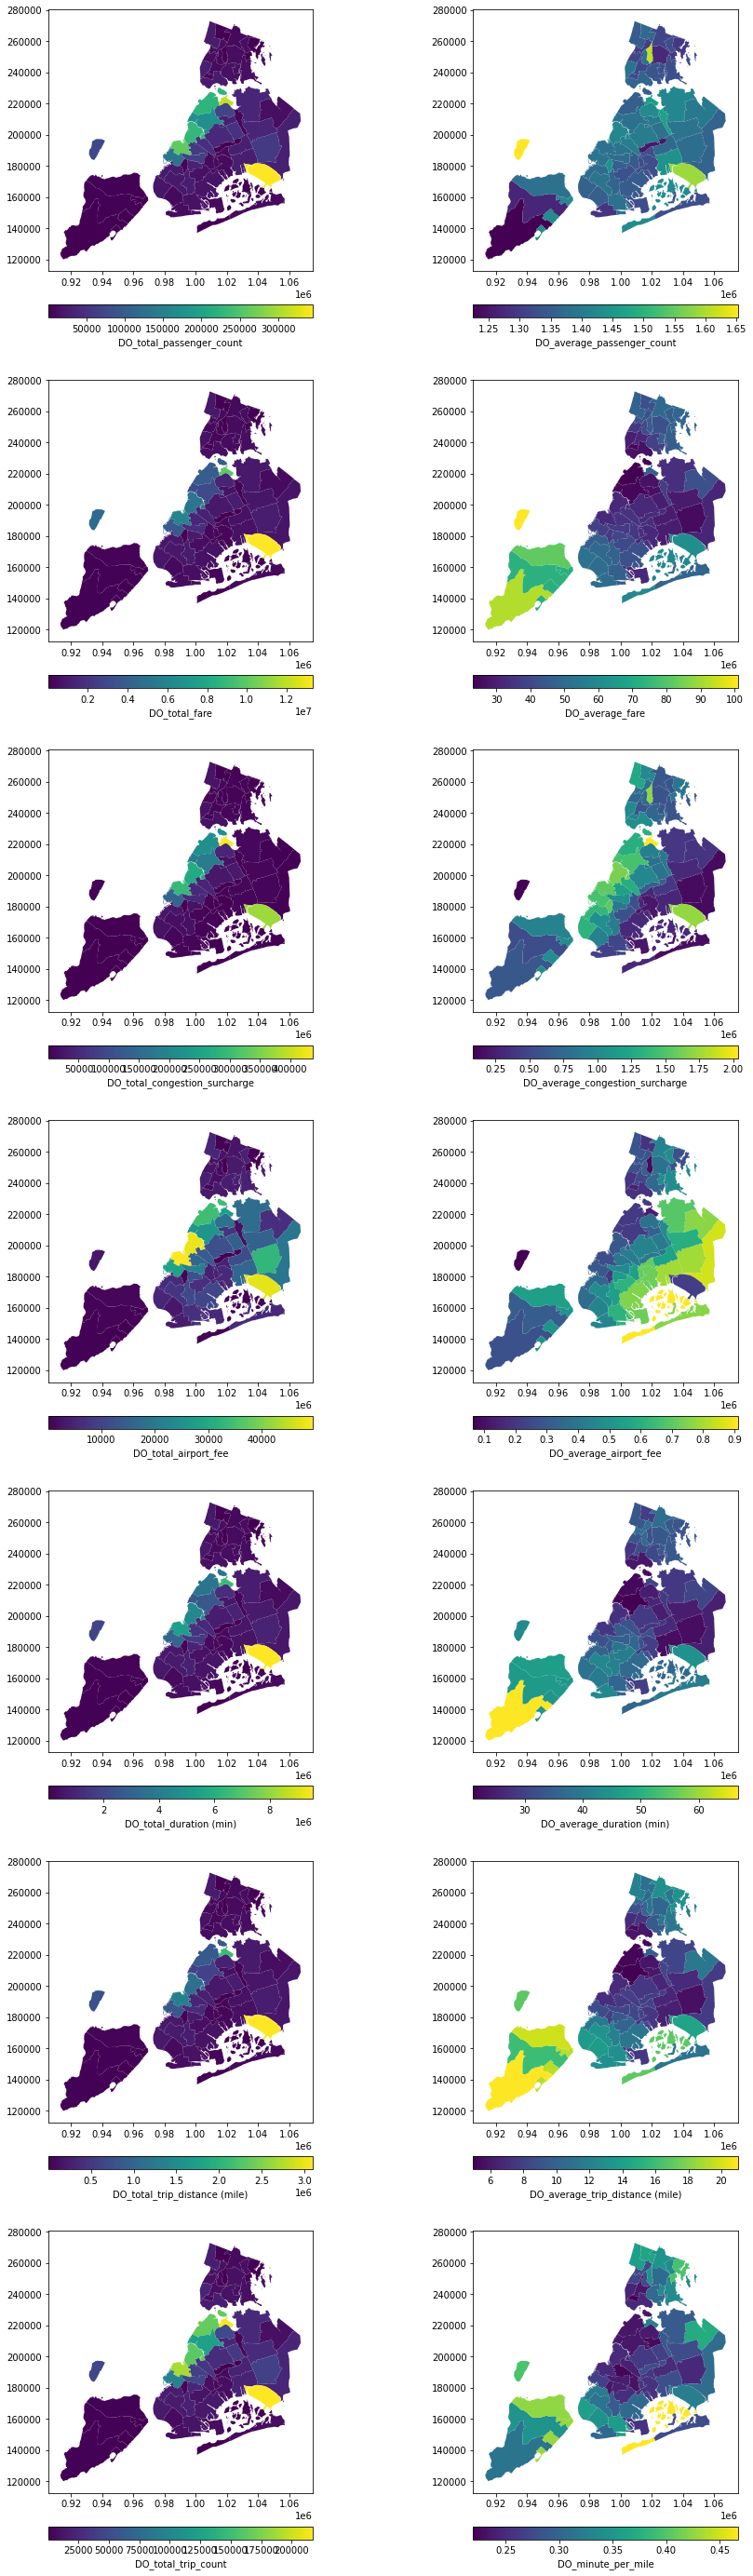

In [8]:
plot_on_map(cdta_df[cdta_df['borough'] != "Manhattan"], pu_do="DO")